# ВЫПУСКНОЙ ПРОЕКТ

Бельского В.Р. слушателя 7 потока курса "Аналитик данных"

Продолжение

In [1]:
# Подключение к  Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Предоставление доступа к аккаунту Google.
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## Импорты необходимых библиотек

In [3]:
!pip install pycaret

In [4]:
!pip install autogluon

In [5]:
!pip install prophet

In [6]:
!pip install phik

In [7]:
# Импорт библиотек.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
#import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from pycaret.clustering import *
from autogluon.tabular import TabularPredictor, TabularDataset
from prophet import Prophet

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

pd.set_option('display.max_columns', None)

## Загрузка исходных файлов

In [8]:
# Загрузка файла.
df = pd.read_csv('/content/drive/MyDrive/Finance University/VP/df_vp21_clear_to_ml.csv')

In [9]:
df.head(2)

ProductKey   OrderDate  CustomerKey  PromotionKey SalesOrderNumber  \
0         310  2014-01-01        21768             1          SO43697   
1         346  2014-01-01        28389             1          SO43698   

   OrderQuantity  ProductCost  ProductPrice  Region Country          Group  \
0              2    2171.2942       3578.27  Canada  Canada  North America   
1              2    1912.1544       3399.99  France  France         Europe   

            FullName MaritalStatus Gender  YearlyIncome  TotalChildren  \
0       Watson, Cole             S      M         70000              5   
1  Martinez, Rachael             S      F         20000              3   

   NumberChildrenAtHome    Education  Occupation  HouseOwnerFlag  \
0                     0    Bachelors  Management               1   
1                     3  High School      Manual               0   

   NumberCarsOwned        AddressLine1 CommuteDistance       City  \
0                3    601 Asilomar Dr.       10+ Miles  Metchosin   
1                0  14, avenue du Port       0-1 Miles     Pantin   

               State              ProductName     SubCategory Category  \
0   British Columbia         Road-150 Red, 62      Road Bikes    Bikes   
1  Seine Saint Denis  Mountain-100 Silver, 44  Mountain Bikes    Bikes   

    Color  DaysToManufacture ProductLine     ModelName  Year  Month  \
0     Red                  4        Road      Road-150  2014      1   
1  Silver                  4    Mountain  Mountain-100  2014      1   

  MonthAndYear  ActualDate  Age  LifeTimeCustomer  LifeTimeProduct  Delay  \
0   2014-01-01  2016-12-30   70              1094             1094      7   
1   2014-01-01  2016-12-30   52              1094             1094      7   

   TotalSales  TotalCost  TaxTotal   Profit  Margin ABC_XYZ_product  \
0     7156.54  4342.5884  572.5232  2241.43   31.32         Removed   
1     6799.98  3824.3088  543.9984  2431.67   35.76         Removed   

  ABC_XYZ_ProductSegment ABC_XYZ_customer ABC_XYZ_CustomerSegment  Recency  R  \
0                Removed               AZ               Irregular      258  1   
1                Removed               AZ               Irregular     1094  1   

   F  M  RFM RFM_segmentation  
0  3  3  133             Risk  
1  2  3  123             Risk

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58189 entries, 0 to 58188
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ProductKey               58189 non-null  int64  
 1   OrderDate                58189 non-null  object 
 2   CustomerKey              58189 non-null  int64  
 3   PromotionKey             58189 non-null  int64  
 4   SalesOrderNumber         58189 non-null  object 
 5   OrderQuantity            58189 non-null  int64  
 6   ProductCost              58189 non-null  float64
 7   ProductPrice             58189 non-null  float64
 8   Region                   58189 non-null  object 
 9   Country                  58189 non-null  object 
 10  Group                    58189 non-null  object 
 11  FullName                 58189 non-null  object 
 12  MaritalStatus            58189 non-null  object 
 13  Gender                   58189 non-null  object 
 14  YearlyIncome          

Данные загружены.

## Прогнозирование прибыли на следующий период

В данной задаче мне нужно прогнозировать прибыль в следующем периоде. Для этого я суммирую прибыль компании по неделям.

### Создание набора данных для прогнозирования временного ряда

In [11]:
# Выделю из даты период по неделям.
df['Week'] = df['OrderDate'].astype('datetime64[W]')

In [12]:
# Сгруппирую прибыль по неделям.
df_profit = df.groupby('Week')['Profit'].sum().reset_index().sort_values(by='Week')
df_profit.head()

Week    Profit
0 2013-12-26   9996.49
1 2014-01-02  42220.99
2 2014-01-09  57964.03
3 2014-01-16  66938.67
4 2014-01-23  58592.13

In [13]:
# Переименую столбцы.
df_profit = df_profit.rename(columns={'Week': 'ds', 'Profit': 'y'})
df_profit.head()

ds         y
0 2013-12-26   9996.49
1 2014-01-02  42220.99
2 2014-01-09  57964.03
3 2014-01-16  66938.67
4 2014-01-23  58592.13

In [14]:
df_profit.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 0 to 157
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      158 non-null    datetime64[ns]
 1   y       158 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 3.7 KB


In [15]:
# Построю временной ряд прибыли.
fig = px.line(df_profit, x='ds', y='y', title='Прибыль')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [16]:
# Определю период прогнозирования в 8 недель.
period = 8

In [17]:
# Разделю данные на тренировочную и тестовую выборки.
train_prophet = df_profit[: -period]
test_prophet = df_profit.drop(train_prophet.index)

In [18]:
# Размер выборок.
print(f'Размер тренировочной выборки: {train_prophet.shape}')
print(f'Размер тестовой выборки: {test_prophet.shape}')

Размер тренировочной выборки: (150, 2)
Размер тестовой выборки: (8, 2)


In [19]:
# Сброшу индексы.
train_prophet = train_prophet.reset_index()
test_prophet = test_prophet.reset_index()

In [20]:
# Последние 5 строк тренировочной выборки.
train_prophet.tail(5)

index         ds          y
145    145 2016-10-06  177963.28
146    146 2016-10-13  210728.01
147    147 2016-10-20  198792.45
148    148 2016-10-27  137709.33
149    149 2016-11-03  232862.84

In [21]:
# Тестовая выборка.
test_prophet

index         ds          y
0    150 2016-11-10  214953.56
1    151 2016-11-17  218399.67
2    152 2016-11-24  316644.20
3    153 2016-12-01  260685.28
4    154 2016-12-08  272812.74
5    155 2016-12-15  261375.62
6    156 2016-12-22  251906.05
7    157 2016-12-29   37323.01

Выборки разделились правильно. Данные для прогнозирования временного ряда подготовлены.

### Прогнозирование прибыли с помощью фреймворка Prophet

In [22]:
# Создаю модель прогнозирования временного ряда Prophet и обучаю ее.
model = Prophet()
model.fit(train_prophet)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3pv3l9c4/oa35rgbe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp3pv3l9c4/2cg9maee.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=25901', 'data', 'file=/tmp/tmp3pv3l9c4/oa35rgbe.json', 'init=/tmp/tmp3pv3l9c4/2cg9maee.json', 'output', 'file=/tmp/tmp3pv3l9c4/prophet_modelb0hk3p29/prophet_model-20231115083520.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
08:35:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
08:35:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [23]:
# Прогнозирование.
prediction = model.predict(pd.DataFrame({'ds':test_prophet['ds']}))
y_predicted = prediction['yhat'].astype(int)

In [24]:
# Актуальные данные
y_actual = test_prophet['y']

In [25]:
# Средняя абсолютная ошибка.
mae = round(mean_absolute_error(y_actual, y_predicted))
print('MAE =', mae)

MAE = 63786


Прогноз прибыли на 8 недель вперед был сделан со средней абсолютной ошибкой MAE = 63786 долларов. Размер прибыли в последнюю неделю предыдущего периода составил 232862 долларов, то есть ошибка составила 27%.

In [26]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=test_prophet['ds'], y=y_actual, name="actual targets"),
    secondary_y=False,)
fig.add_trace(
    go.Scatter(x=test_prophet['ds'], y=y_predicted, name="predicted targets"),
    secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

На графике видно, что прогноз на первые 4 недели достаточно точный. Это говорит о том, что для точного прогнозирования не 8 недель вперед нужно использовать более длительный период исходных данных.

<b>Вывод:</b>

Для построения модели прогнозирования прибыли на следующий период был использован фреймворк автоматического машинного обучения Prophet.

Из исходных данных был выделен временной ряд, содержащий агрегированную по неделям прибыль. Период прогнозирования был определен размером в 8 недель. Из временного ряда были выделены тестовая выборка рамеров в 8 недель и тренировочная выборка, включающая все оставшиеся данные.

На тренировочной выборке была обучена модель и с ее помощью на выделенном из тестовой выборки временном интервале был сделан прогноз прибыли.

Средняя абсолютная ошибка прогноза MAE составила 63786 долларов. Размер прибыли в последнюю неделю предыдущего периода составил 232862 долларов, то есть ошибка составила 27%.

На построенном графике актуального и прогнозированного временных радов видно, что прогноз на первые 4 недели достаточно точный. Это говорит о том, что для точного прогнозирования не 8 недель вперед нужно использовать более длительный период исходных данных.

## Кластеризация покупателей

Для решения задачи кластеризации создам агрегированный по покупателям датафрейм.

In [27]:
# Список признаков для агрегации.
columns_agg = ['CustomerKey', 'Age', 'MaritalStatus', 'Gender', 'YearlyIncome',
               'Education',  'Occupation', 'TotalChildren', 'NumberChildrenAtHome',
               'HouseOwnerFlag', 'NumberCarsOwned', 'CommuteDistance',
               'Group', 'Region', 'Country', 'State', 'City', 'Recency', 'F', 'M']

In [28]:
# Группировка по покупателям.
df_claster = df.groupby(columns_agg).agg({'OrderQuantity':'count'}).reset_index()
df_claster.head()

CustomerKey  Age MaritalStatus Gender  YearlyIncome  Education  \
0        11000   50             M      M         90000  Bachelors   
1        11001   51             S      M         60000  Bachelors   
2        11002   51             M      M         60000  Bachelors   
3        11003   48             S      F         70000  Bachelors   
4        11004   48             S      F         80000  Bachelors   

     Occupation  TotalChildren  NumberChildrenAtHome  HouseOwnerFlag  \
0  Professional              2                     0               1   
1  Professional              3                     3               0   
2  Professional              3                     3               1   
3  Professional              0                     0               0   
4  Professional              5                     5               1   

   NumberCarsOwned CommuteDistance    Group     Region    Country  \
0                0       1-2 Miles  Pacific  Australia  Australia   
1                1       0-1 Miles  Pacific  Australia  Australia   
2                1       2-5 Miles  Pacific  Australia  Australia   
3                1      5-10 Miles  Pacific  Australia  Australia   
4                4       1-2 Miles  Pacific  Australia  Australia   

             State         City  Recency  F  M  OrderQuantity  
0       Queensland  Rockhampton      240  3  3              8  
1         Victoria      Seaford       18  3  3             11  
2         Tasmania       Hobart      307  3  3              4  
3  New South Wales   North Ryde      233  3  3              9  
4  New South Wales   Wollongong      242  3  3              6

In [29]:
df_claster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   CustomerKey           17918 non-null  int64 
 1   Age                   17918 non-null  int64 
 2   MaritalStatus         17918 non-null  object
 3   Gender                17918 non-null  object
 4   YearlyIncome          17918 non-null  int64 
 5   Education             17918 non-null  object
 6   Occupation            17918 non-null  object
 7   TotalChildren         17918 non-null  int64 
 8   NumberChildrenAtHome  17918 non-null  int64 
 9   HouseOwnerFlag        17918 non-null  int64 
 10  NumberCarsOwned       17918 non-null  int64 
 11  CommuteDistance       17918 non-null  object
 12  Group                 17918 non-null  object
 13  Region                17918 non-null  object
 14  Country               17918 non-null  object
 15  State                 17918 non-null

In [30]:
# Приведу рад признаков к категориальному типу с учетом порядка
df_claster['TotalChildren'] = df_claster['TotalChildren'].astype('category').cat.set_categories([0, 1, 2, 3, 4, 5], ordered=True)
df_claster['NumberChildrenAtHome'] = df_claster['NumberChildrenAtHome'].astype('category').cat.set_categories([0, 1, 2, 3, 4, 5], ordered=True)
df_claster['NumberCarsOwned'] = df_claster['NumberCarsOwned'].astype('category').cat.set_categories([0, 1, 2, 3, 4], ordered=True)
df_claster['Education'] = df_claster['Education'].astype('category').cat.set_categories(['Partial High School', 'High School', 'Partial College',
       'Bachelors', 'Graduate Degree'], ordered=True)
df_claster['CommuteDistance'] = df_claster['CommuteDistance'].astype('category').cat.set_categories(
    ['0-1 Miles', '1-2 Miles', '2-5 Miles', '5-10 Miles', '10+ Miles'], ordered=True)
df_claster['F'] = df_claster['F'].astype('category').cat.set_categories([1, 2, 3], ordered=True)
df_claster['M'] = df_claster['M'].astype('category').cat.set_categories([1, 2, 3], ordered=True)
df_claster['CommuteDistance'].dtypes

CategoricalDtype(categories=['0-1 Miles', '1-2 Miles', '2-5 Miles', '5-10 Miles',
                  '10+ Miles'],
, ordered=True)

In [31]:
# Приведу ряд столбцов к категориальному типу.
df_claster['MaritalStatus'] = df_claster['MaritalStatus'].astype('category')
df_claster['Gender'] = df_claster['Gender'].astype('category')
df_claster['Occupation'] = df_claster['Occupation'].astype('category')
df_claster['HouseOwnerFlag'] = df_claster['HouseOwnerFlag'].astype('category')
df_claster['Group'] = df_claster['Group'].astype('category')
df_claster['Region'] = df_claster['Region'].astype('category')
df_claster['Country'] = df_claster['Country'].astype('category')
df_claster['State'] = df_claster['State'].astype('category')
df_claster['City'] = df_claster['City'].astype('category')
df_claster['City'].dtypes

CategoricalDtype(categories=['Ballard', 'Barstow', 'Basingstoke Hants', 'Baytown',
                  'Beaverton', 'Bell Gardens', 'Bellevue', 'Bellflower',
                  'Bellingham', 'Bendigo',
                  ...
                  'West Covina', 'West Sussex', 'Westminster', 'Wokingham',
                  'Wollongong', 'Woodburn', 'Woodland Hills', 'Woolston',
                  'Yakima', 'York'],
, ordered=False)

In [32]:
df_claster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   CustomerKey           17918 non-null  int64   
 1   Age                   17918 non-null  int64   
 2   MaritalStatus         17918 non-null  category
 3   Gender                17918 non-null  category
 4   YearlyIncome          17918 non-null  int64   
 5   Education             17918 non-null  category
 6   Occupation            17918 non-null  category
 7   TotalChildren         17918 non-null  category
 8   NumberChildrenAtHome  17918 non-null  category
 9   HouseOwnerFlag        17918 non-null  category
 10  NumberCarsOwned       17918 non-null  category
 11  CommuteDistance       17918 non-null  category
 12  Group                 17918 non-null  category
 13  Region                17918 non-null  category
 14  Country               17918 non-null  category
 15  St

In [33]:
# Инициализация среды PyCaret.
s = setup(df_claster, normalize = False, ignore_features =['CustomerKey', 'Recency'], session_id = 42)

In [34]:
# Создание модели K-means с числом кластеров 4.
kmeans4 = create_model('kmeans' , num_clusters=4)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

Обученная модель показала значение метрики Silhouette = 0.6375. Это значение ниже 1, значит решение можно еще оптимизировать.

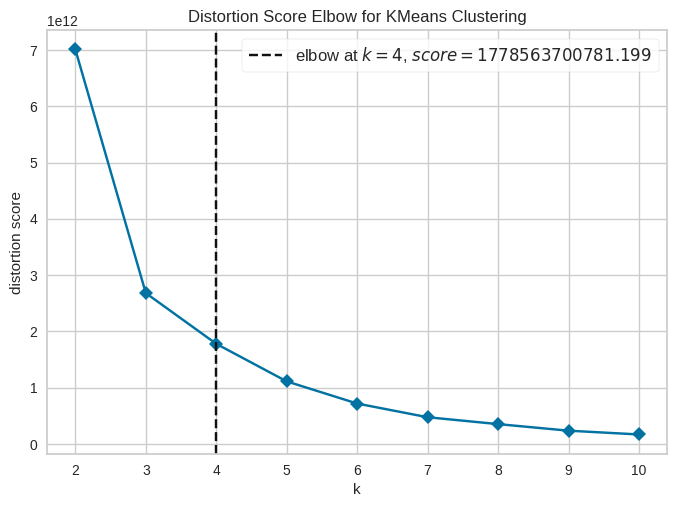

In [35]:
# Оценка необходимого числа кластеров методом локтя.
plot_model(kmeans4, plot = 'elbow')

In [36]:
# Визуализация модели
plot_model(kmeans4)

На диаграмме локтя видно, как медленно стремится к нулю метрика distortion, которая характеризует искажение. Вероятно, оптимальное число кластеров может быть больше 10. Однако, для наших целей такое большое число кластеров не годится. Программно подобранно наилучшее число кластеров, равное 4. Но на диаграмме локтя видно, что метрика distortion продолжает сильно меняться после 4 кластеров. На визуализации модели кажутся отделенными друг от друга три нруппы точек. И на диаграмме локтя перегиб находится на отметке 3-х кластеров. Попробую сделать количество кластеров равным 3.

In [37]:
# Создание модели K-means с числом кластеров 3.
kmeans3 = create_model('kmeans' , num_clusters=3)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [38]:
# Визуализация модели с 3 кластерами.
plot_model(kmeans3)

Значение Silhouette немного увеличилось. Но отдельно стоящая группа по прежнему находится не в отдельном кластере. Кроме того, индекс Калински-Харабаша (отношение суммы межкластерной дисперсии к сумме внутрикластерной дисперсии для всех кластеров, где дисперсия представляет собой сумму квадратов расстояний)уменьшился. Значит качество разбиения на кластеры ухудшилось. Индекс Дэвиса-Булдина (рассчитываемого как среднее сходство каждого кластера с кластером, наиболее похожим на него) уменьшился. Что также говорит об ухудшении качества разбиения. Поэтому попробую увеличить количество кластеров, чтобы добиться выделения отдельно стоящей группы. Проверю разбиение на 6 кластеров.

In [39]:
# Создание модели K-means с числом кластеров 6.
kmeans6 = create_model('kmeans', num_clusters=6)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [40]:
# Визуализация модели
plot_model(kmeans6)

Оценка силуэта, индекс Калински-Харабаша и индекс Дэвиса-Булдина немного улучшились. Отдельно стоящая группа оказалась в своем кластере. Вероятно, это лучший вариант разбиения. На всякий случай проверю еще разбиение на 9 кластеров.

In [41]:
# Создание модели K-means с числом кластеров 9.
kmeans9 = create_model('kmeans', num_clusters=9)

Processing:   0%|          | 0/3 [00:00<?, ?it/s]

In [42]:
# Визуализация модели
plot_model(kmeans9)

При разбиении на 9 кластеров значения всех показателей оказались самыми лучшими. Отдельно стоящая группа, по прежнему выделена в отдельный кластер. Считаю разбиение на 9 кластеров самым оптимальным вариантом.

In [43]:
# Присвою метки кластеров набору данных.
kmean_results = assign_model(kmeans9)
kmean_results.head()

Age MaritalStatus Gender  YearlyIncome  Education    Occupation  \
0   50             M      M         90000  Bachelors  Professional   
1   51             S      M         60000  Bachelors  Professional   
2   51             M      M         60000  Bachelors  Professional   
3   48             S      F         70000  Bachelors  Professional   
4   48             S      F         80000  Bachelors  Professional   

  TotalChildren NumberChildrenAtHome HouseOwnerFlag NumberCarsOwned  \
0             2                    0              1               0   
1             3                    3              0               1   
2             3                    3              1               1   
3             0                    0              0               1   
4             5                    5              1               4   

  CommuteDistance    Group     Region    Country            State  \
0       1-2 Miles  Pacific  Australia  Australia       Queensland   
1       0-1 Miles  Pacific  Australia  Australia         Victoria   
2       2-5 Miles  Pacific  Australia  Australia         Tasmania   
3      5-10 Miles  Pacific  Australia  Australia  New South Wales   
4       1-2 Miles  Pacific  Australia  Australia  New South Wales   

          City  F  M  OrderQuantity    Cluster  
0  Rockhampton  3  3              8  Cluster 4  
1      Seaford  3  3             11  Cluster 0  
2       Hobart  3  3              4  Cluster 0  
3   North Ryde  3  3              9  Cluster 7  
4   Wollongong  3  3              6  Cluster 4

In [44]:
kmean_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   17918 non-null  int8    
 1   MaritalStatus         17918 non-null  category
 2   Gender                17918 non-null  category
 3   YearlyIncome          17918 non-null  int32   
 4   Education             17918 non-null  category
 5   Occupation            17918 non-null  category
 6   TotalChildren         17918 non-null  category
 7   NumberChildrenAtHome  17918 non-null  category
 8   HouseOwnerFlag        17918 non-null  category
 9   NumberCarsOwned       17918 non-null  category
 10  CommuteDistance       17918 non-null  category
 11  Group                 17918 non-null  category
 12  Region                17918 non-null  category
 13  Country               17918 non-null  category
 14  State                 17918 non-null  category
 15  Ci

In [45]:
# Объединю по значениям индекса уникальный номер покупателя с названием кластера.
kmean_results = df_claster.merge(kmean_results, how='left', left_index=True, right_index=True)
kmean_results = kmean_results[['CustomerKey', 'Cluster']]
kmean_results.head()

CustomerKey    Cluster
0        11000  Cluster 4
1        11001  Cluster 0
2        11002  Cluster 0
3        11003  Cluster 7
4        11004  Cluster 4

In [46]:
kmean_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17918 entries, 0 to 17917
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CustomerKey  17918 non-null  int64 
 1   Cluster      17918 non-null  object
dtypes: int64(1), object(1)
memory usage: 280.1+ KB


In [47]:
# Соединю исходные данные и номер кластера.
clasters = kmean_results.merge(df_claster, how='left', on='CustomerKey')[['CustomerKey', 'Cluster']]
clasters.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17918 entries, 0 to 17917
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   CustomerKey  17918 non-null  int64 
 1   Cluster      17918 non-null  object
dtypes: int64(1), object(1)
memory usage: 420.0+ KB


С помощью фреймворка автоматического машинного обучения PyCaret методом К средних покупатели были разделены на 9 кластеров. При разбиении удалось достичь следующих значений показателей: оценка силуэта = 0.8, индекс Калински-Харабаша = 175466 и индекс Дэвиса-Булдина = 0.36. Результаты анализа могут быть добавлены в справочник кличентов.

## Прогнозирование оттока клиентов.

Для прогнозирования ухода покупателей буду использовать агрегированный по покупателям датафрейм из задачи кластеризации. Создам в нем категориальный признак оттока покупателей. Буду считать покупателя ушедшим, если дата его последней покупки ранее  одного года с даты конца периода.

### Подготовка данных

In [48]:
# Функция определения факта ухода покупателя.
def churn(recency):
  if recency > 365:
    ch = 1
  else:
    ch = 0
  return ch

In [49]:
# Создание признака Churn
df_claster['Churn'] = df_claster['Recency'].agg(churn).astype('category')
df.head()

ProductKey   OrderDate  CustomerKey  PromotionKey SalesOrderNumber  \
0         310  2014-01-01        21768             1          SO43697   
1         346  2014-01-01        28389             1          SO43698   
2         346  2014-01-01        25863             1          SO43699   
3         336  2014-01-01        14501             1          SO43700   
4         346  2014-01-01        11003             1          SO43701   

   OrderQuantity  ProductCost  ProductPrice     Region        Country  \
0              2    2171.2942     3578.2700     Canada         Canada   
1              2    1912.1544     3399.9900     France         France   
2              2    1912.1544     3399.9900  Northwest  United States   
3              2     413.1463      699.0982  Southwest  United States   
4              2    1912.1544     3399.9900  Australia      Australia   

           Group           FullName MaritalStatus Gender  YearlyIncome  \
0  North America       Watson, Cole             S      M         70000   
1         Europe  Martinez, Rachael             S      F         20000   
2  North America     Wright, Sydney             S      F         40000   
3  North America      Prasad, Ruben             M      M         80000   
4        Pacific       Zhu, Christy             S      F         70000   

   TotalChildren  NumberChildrenAtHome        Education    Occupation  \
0              5                     0        Bachelors    Management   
1              3                     3      High School        Manual   
2              5                     0      High School  Professional   
3              4                     0  Graduate Degree    Management   
4              0                     0        Bachelors  Professional   

   HouseOwnerFlag  NumberCarsOwned         AddressLine1 CommuteDistance  \
0               1                3     601 Asilomar Dr.       10+ Miles   
1               0                0   14, avenue du Port       0-1 Miles   
2               1                3  4193 E. 28th Street       10+ Miles   
3               1                2    249 Alexander Pl.       1-2 Miles   
4               0                1     1825 Village Pl.      5-10 Miles   

            City              State              ProductName     SubCategory  \
0      Metchosin   British Columbia         Road-150 Red, 62      Road Bikes   
1         Pantin  Seine Saint Denis  Mountain-100 Silver, 44  Mountain Bikes   
2        Lebanon             Oregon  Mountain-100 Silver, 44  Mountain Bikes   
3  Beverly Hills         California       Road-650 Black, 62      Road Bikes   
4     North Ryde    New South Wales  Mountain-100 Silver, 44  Mountain Bikes   

  Category   Color  DaysToManufacture ProductLine     ModelName  Year  Month  \
0    Bikes     Red                  4        Road      Road-150  2014      1   
1    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   
2    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   
3    Bikes   Black                  4        Road      Road-650  2014      1   
4    Bikes  Silver                  4    Mountain  Mountain-100  2014      1   

  MonthAndYear  ActualDate  Age  LifeTimeCustomer  LifeTimeProduct  Delay  \
0   2014-01-01  2016-12-30   70              1094             1094      7   
1   2014-01-01  2016-12-30   52              1094             1094      7   
2   2014-01-01  2016-12-30   70              1094             1094      7   
3   2014-01-01  2016-12-30   78              1094             1094      7   
4   2014-01-01  2016-12-30   48              1094             1094      7   

   TotalSales  TotalCost  TaxTotal   Profit  Margin ABC_XYZ_product  \
0   7156.5400  4342.5884  572.5232  2241.43   31.32         Removed   
1   6799.9800  3824.3088  543.9984  2431.67   35.76         Removed   
2   6799.9800  3824.3088  543.9984  2431.67   35.76         Removed   
3   1398.1964   826.2926  111.8558   460.05   32.90         Removed   
4   6799.9

Признак оттока добавлен в датафрейм.

In [50]:
df_claster['Churn'].value_counts()

0    17412
1      506
Name: Churn, dtype: int64

Количество ушедших покупателей значительно меньше оставшихся с компанией. Это говорит о сильном дисбалансе классов.

In [51]:
df_churn = df_claster.drop('Recency', axis=1)

In [52]:
df_churn = df_churn.set_index('CustomerKey')

interval columns not set, guessing: ['Age', 'YearlyIncome', 'OrderQuantity']


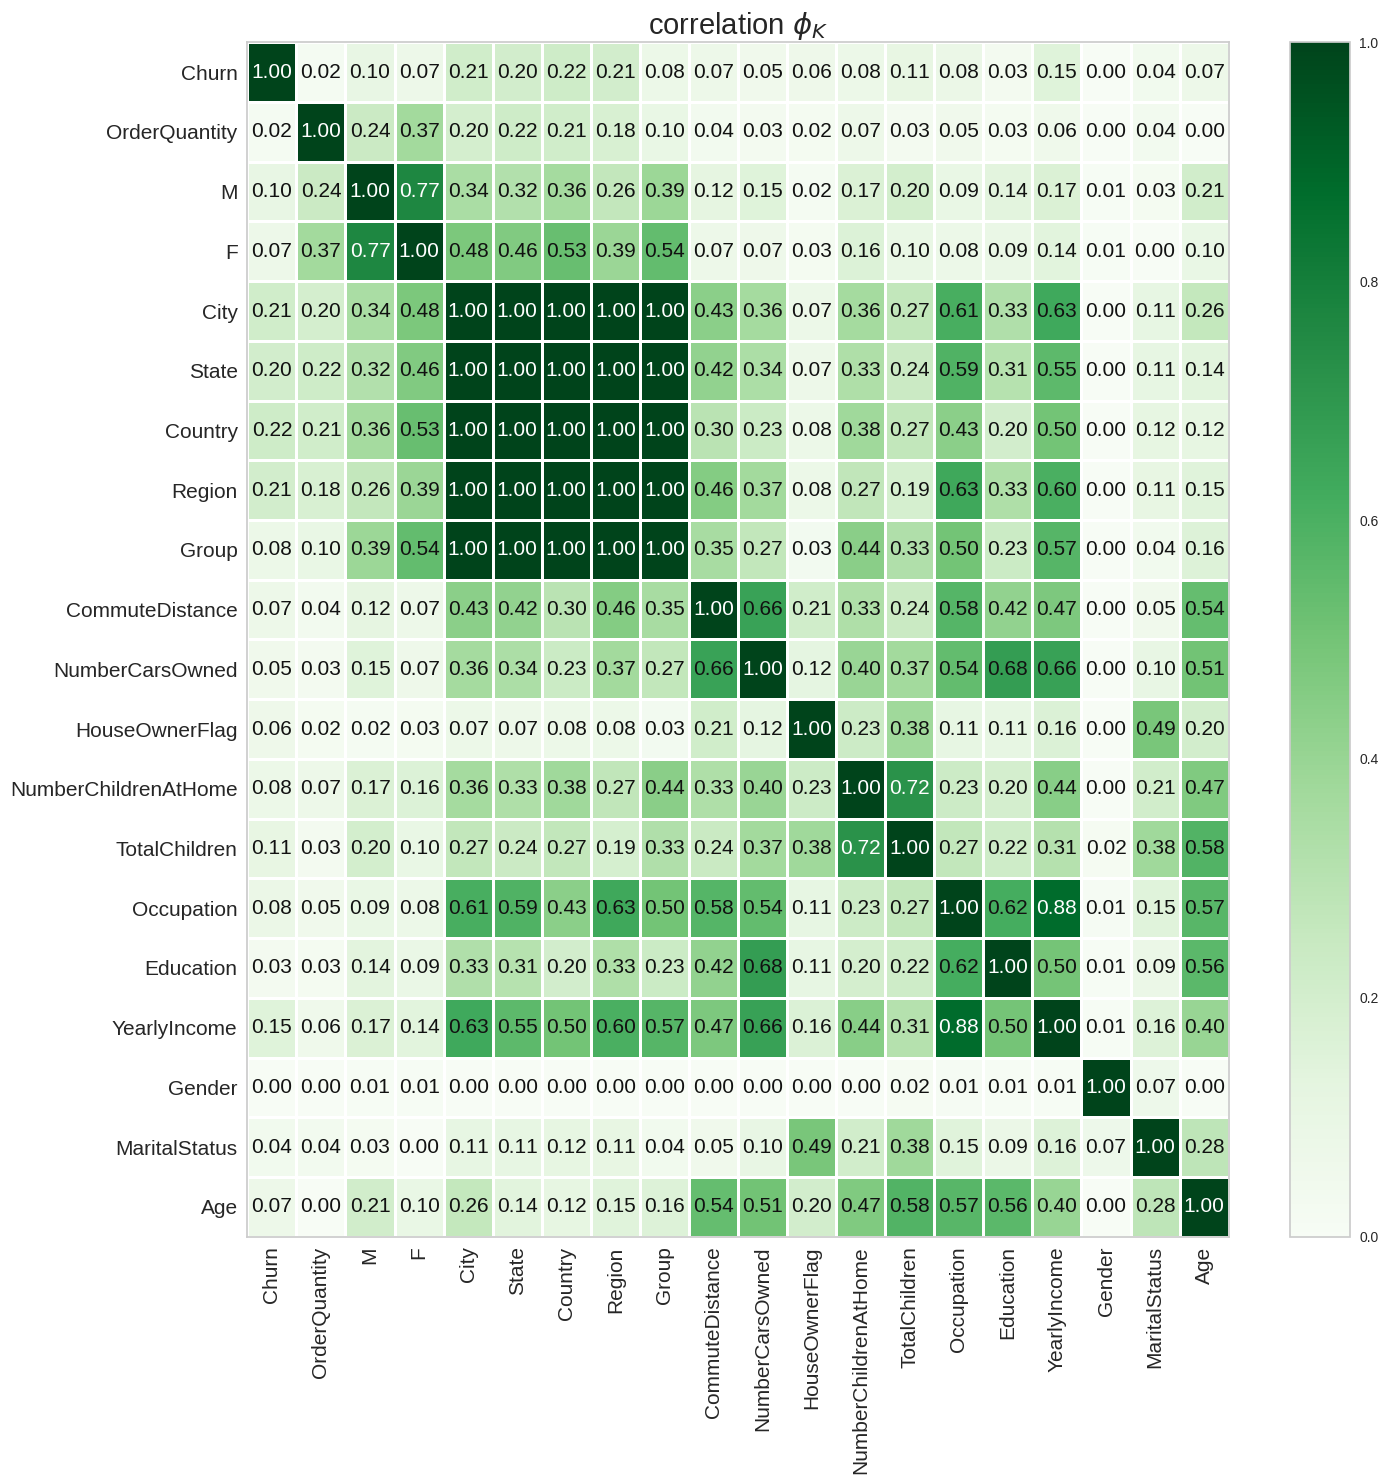

In [53]:
# Матрица корреляции признаков.
data_corr_phik = df_churn.phik_matrix()

plot_correlation_matrix(data_corr_phik.values,
                        x_labels=data_corr_phik.columns,
                        y_labels=data_corr_phik.index,
                        vmin=0, vmax=1, color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5,
                        figsize=(15, 15))

У геогрфических признаков Group, Region, Country, State и City взаимная корреляция равна 1. Для устранения такой взаимной корреляции создам признак CountryAndCity, а остальные географические признаки удалю.

In [54]:
df_churn['Country'] = df_churn['Country'].astype('object')
df_churn['City'] = df_churn['City'].astype('object')
df_churn['CountryAndCity'] = df_churn['Country'] + ', ' + df_churn['City']
df_churn.head()

Age MaritalStatus Gender  YearlyIncome  Education    Occupation  \
CustomerKey                                                                    
11000         50             M      M         90000  Bachelors  Professional   
11001         51             S      M         60000  Bachelors  Professional   
11002         51             M      M         60000  Bachelors  Professional   
11003         48             S      F         70000  Bachelors  Professional   
11004         48             S      F         80000  Bachelors  Professional   

            TotalChildren NumberChildrenAtHome HouseOwnerFlag NumberCarsOwned  \
CustomerKey                                                                     
11000                   2                    0              1               0   
11001                   3                    3              0               1   
11002                   3                    3              1               1   
11003                   0                    0              0               1   
11004                   5                    5              1               4   

            CommuteDistance    Group     Region    Country            State  \
CustomerKey                                                                   
11000             1-2 Miles  Pacific  Australia  Australia       Queensland   
11001             0-1 Miles  Pacific  Australia  Australia         Victoria   
11002             2-5 Miles  Pacific  Australia  Australia         Tasmania   
11003            5-10 Miles  Pacific  Australia  Australia  New South Wales   
11004             1-2 Miles  Pacific  Australia  Australia  New South Wales   

                    City  F  M  OrderQuantity Churn          CountryAndCity  
CustomerKey                                                                  
11000        Rockhampton  3  3              8     0  Australia, Rockhampton  
11001            Seaford  3  3             11     0      Australia, Seaford  
11002             Hobart  3  3              4     0       Australia, Hobart  
11003         North Ryde  3  3              9     0   Australia, North Ryde  
11004         Wollongong  3  3              6     0   Australia, Wollongong

In [55]:
df_churn = df_churn.drop(columns=['Group', 'Region', 'Country', 'State', 'City'])

In [56]:
df_churn['CountryAndCity'] = df_churn['CountryAndCity'].astype('category')

interval columns not set, guessing: ['Age', 'YearlyIncome', 'OrderQuantity']


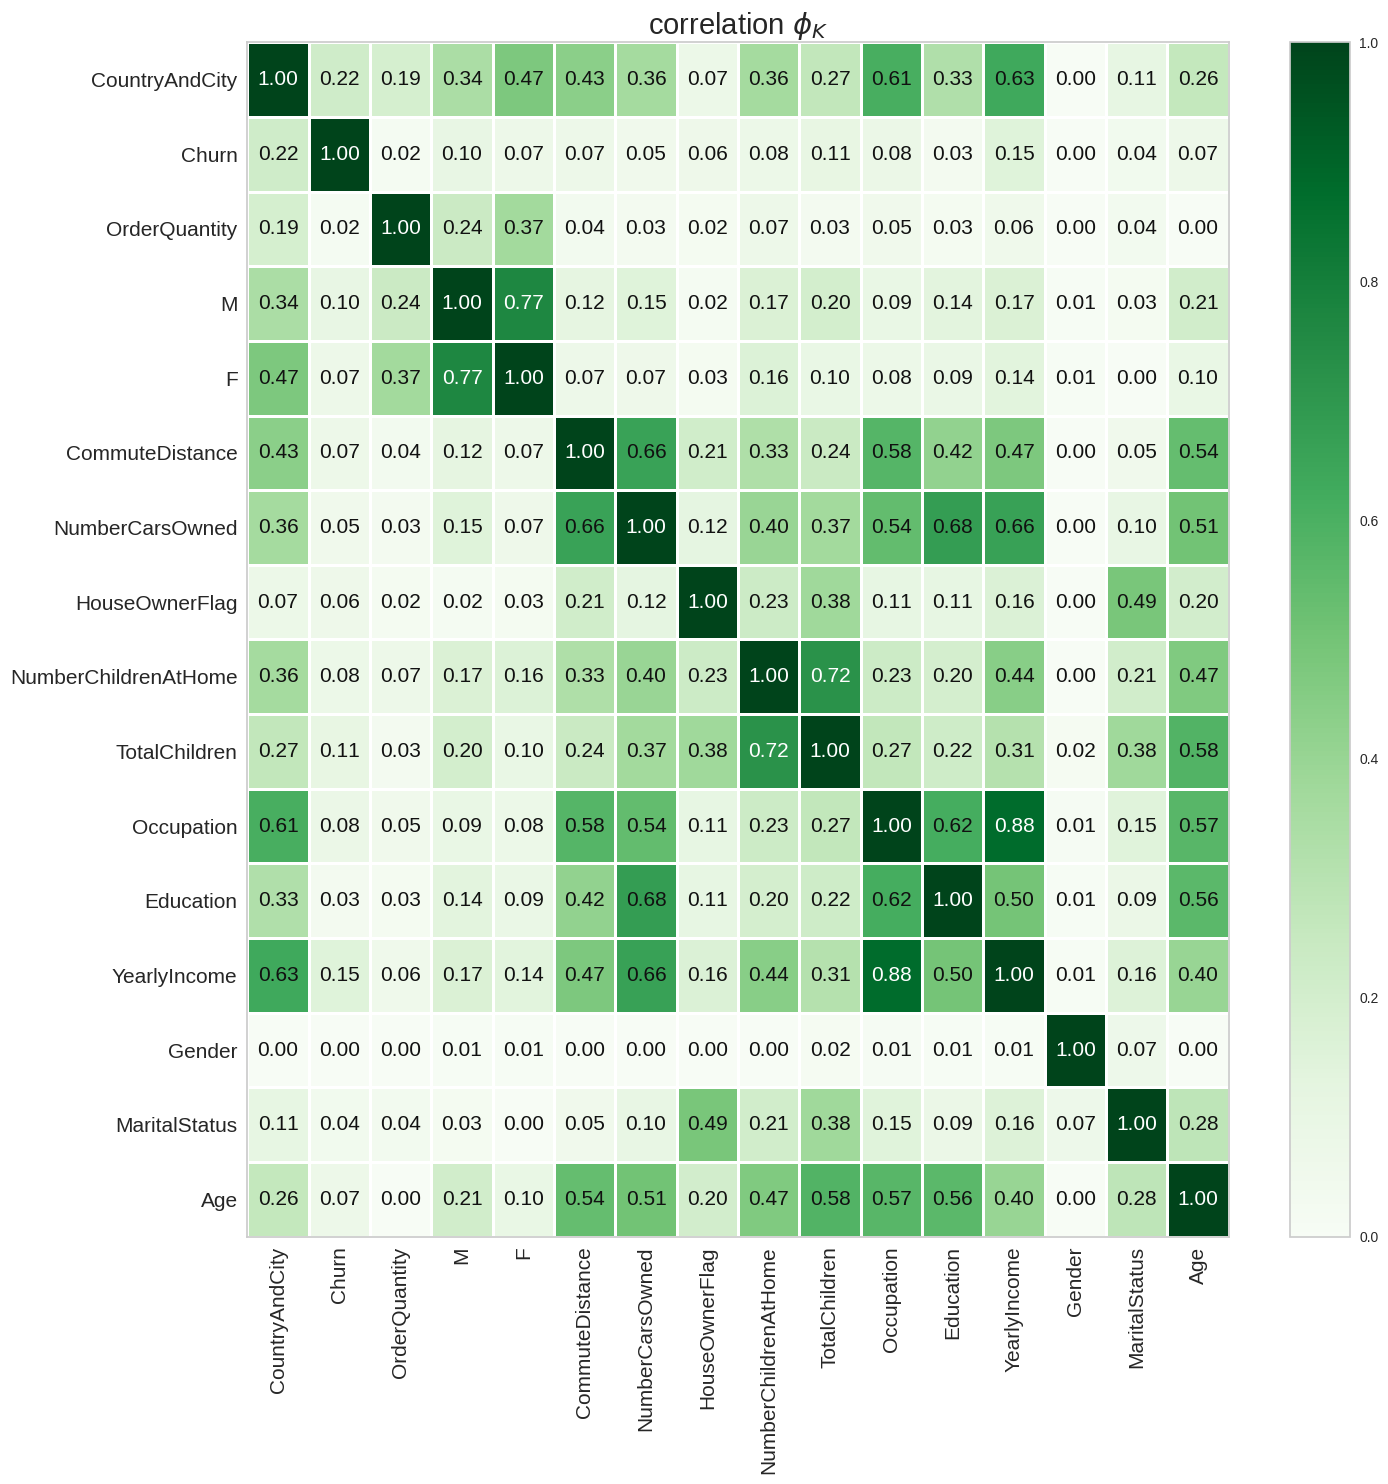

In [57]:
# Матрица корреляции признаков.
data_corr_phik = df_churn.phik_matrix()

plot_correlation_matrix(data_corr_phik.values,
                        x_labels=data_corr_phik.columns,
                        y_labels=data_corr_phik.index,
                        vmin=0, vmax=1, color_map='Greens',
                        title=r'correlation $\phi_K$',
                        fontsize_factor=1.5,
                        figsize=(15, 15))

От сильно коррелирующих признаков удалось избавиться. Признак Gender имеет практически нулевую корреляцию со всеми признаками, включая целевой. Его также можно удалить из рассмотрения.

In [58]:
df_churn = df_churn.drop('Gender', axis=1)

In [59]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17918 entries, 11000 to 29483
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Age                   17918 non-null  int64   
 1   MaritalStatus         17918 non-null  category
 2   YearlyIncome          17918 non-null  int64   
 3   Education             17918 non-null  category
 4   Occupation            17918 non-null  category
 5   TotalChildren         17918 non-null  category
 6   NumberChildrenAtHome  17918 non-null  category
 7   HouseOwnerFlag        17918 non-null  category
 8   NumberCarsOwned       17918 non-null  category
 9   CommuteDistance       17918 non-null  category
 10  F                     17918 non-null  category
 11  M                     17918 non-null  category
 12  OrderQuantity         17918 non-null  int64   
 13  Churn                 17918 non-null  category
 14  CountryAndCity        17918 non-null  category
dty

Признаки подготовлены к разделению на тренировочную и тестовую выборки.

### Прогнозирование оттока покупателей без учета разбиения на кластеры.

In [60]:
# Разделю датафрейм на тренировочную и тестовую выборки.
train_data, test_data = train_test_split(df_churn, test_size=0.2, shuffle=True, stratify=df_churn['Churn'], random_state=42)

In [61]:
train_data.shape, test_data.shape

((14334, 15), (3584, 15))

In [62]:
train_data['Churn'].value_counts()

0    13929
1      405
Name: Churn, dtype: int64

In [63]:
test_data['Churn'].value_counts()

0    3483
1     101
Name: Churn, dtype: int64

In [64]:
# Соотношение единиц и нулей в тренировочной выборке.
len(train_data.loc[train_data['Churn']==1, 'Churn']) / len(train_data.loc[train_data['Churn']==0, 'Churn'])

0.029076028429894464

In [65]:
# Соотношение единиц и нулей в тестовой выборке.
len(test_data.loc[test_data['Churn']==1, 'Churn']) / len(test_data.loc[test_data['Churn']==0, 'Churn'])

0.028997990238300315

Выборки разделились с сохранением соотношения классов.

In [66]:
# Объявляю целевой признак.
label = 'Churn'

In [67]:
# Объявляю путь для сохранения модели.
save_path = 'agModels-predictClass'

In [68]:
# Обучаю AutoGluon на тренировочных данных и сохраняю его по указанному пути.
predictor = TabularPredictor(label=label, path=save_path).fit(train_data)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   79.35 GB / 115.66 GB (68.6%)
Train Data Rows:    14334
Train Data Columns: 14
Label Column: Churn
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11646.35 MB
	Train Data (Original)  Memory Usage: 0.54 MB (0.0% of available mem

In [69]:
# Выделяю из тестовых данных целевой признак.
y_test = test_data[label]
test_nolab = test_data.drop(columns=[label])

In [70]:
# Загружаю сохраненный предиктор.
predictor_saved = TabularPredictor.load(save_path)

In [71]:
# Делаю прогноз.
y_pred = predictor_saved.predict(test_nolab)

In [72]:
# Первые и последние 5 строк прогноза.
print('Predictions:  \n', y_pred)

Predictions:  
 CustomerKey
22886    0
21752    0
17099    0
19441    0
15997    0
        ..
15777    0
27673    1
20594    0
19862    0
13633    0
Name: Churn, Length: 3584, dtype: object


In [73]:
# Вычисление метрик на тестовых данных.
perf = predictor_saved.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9840959821428571
Evaluations on test data:
{
    "accuracy": 0.9840959821428571,
    "balanced_accuracy": 0.8379952982378341,
    "mcc": 0.7000054776854047,
    "f1": 0.7076923076923077,
    "precision": 0.7340425531914894,
    "recall": 0.6831683168316832
}


In [74]:
# Сводная таблица результатов предсказания целевого признака моделями фреймворка AutoGluon.
predictor_saved.leaderboard(test_data)

                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0              CatBoost    0.986607   0.990934        0.034685       0.022948  12.475949                 0.034685                0.022948          12.475949            1       True          7
1         LightGBMLarge    0.986328   0.991632        0.073098       0.029149   1.973562                 0.073098                0.029149           1.973562            1       True         13
2      RandomForestGini    0.986328   0.989540        0.241624       0.162031   2.562353                 0.241624                0.162031           2.562353            1       True          5
3      RandomForestEntr    0.986049   0.989540        0.223827       0.153487   2.503202                 0.223827                0.153487           2.503202            1       True          6
4            LightGBMXT    0.985491   0.

model  score_test  score_val  pred_time_test  pred_time_val  \
0              CatBoost    0.986607   0.990934        0.034685       0.022948   
1         LightGBMLarge    0.986328   0.991632        0.073098       0.029149   
2      RandomForestGini    0.986328   0.989540        0.241624       0.162031   
3      RandomForestEntr    0.986049   0.989540        0.223827       0.153487   
4            LightGBMXT    0.985491   0.983264        0.242136       0.097651   
5              LightGBM    0.984096   0.991632        0.016375       0.018510   
6   WeightedEnsemble_L2    0.984096   0.992329        0.094778       0.053725   
7               XGBoost    0.983538   0.990934        0.050128       0.031087   
8        ExtraTreesGini    0.983259   0.983961        0.310088       0.158777   
9        ExtraTreesEntr    0.983259   0.983264        0.314795       0.148131   
10      NeuralNetFastAI    0.982980   0.986053        0.120693       0.044569   
11       NeuralNetTorch    0.979911   0.988145        0.061732       0.043637   
12       KNeighborsUnif    0.977958   0.981172        0.047362       0.048289   
13       KNeighborsDist    0.977958   0.980474        0.057679       0.039439   

     fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0   12.475949                 0.034685                0.022948   
1    1.973562                 0.073098                0.029149   
2    2.562353                 0.241624                0.162031   
3    2.503202                 0.223827                0.153487   
4    3.842026                 0.242136                0.097651   
5    1.004093                 0.016375                0.018510   
6    5.193959                 0.005305                0.006066   
7    2.277365                 0.050128                0.031087   
8    2.374414                 0.310088                0.158777   
9    2.444534                 0.314795                0.148131   
10  18.810286                 0.120693                0.044569   
11  55.643265                 0.061732                0.043637   
12   2.336355                 0.047362                0.048289   
13   0.028322                 0.057679                0.039439   

    fit_time_marginal  stack_level  can_infer  fit_order  
0           12.475949            1       True          7  
1            1.973562            1       True         13  
2            2.562353            1       True          5  
3            2.503202            1       True          6  
4            3.842026            1       True          3  
5            1.004093            1       True          4  
6            2.216305            2       True         14  
7            2.277365            1       True         11  
8            2.374414            1       True          8  
9            2.444534            1       True          9  
10          18.810286            1       True         10  
11          55.643265            1       True         12  
12           2.336355            1       True          1  
13           0.028322            1       True          2

Фреймворк AutoGluon обучил 13 моделей. Лучший результат показала модель RandomForest с критерием entropy. Она показала на тестовой выборке значение метрики F1-мера = 0.75, precision=0.66, recall=0.86.

In [75]:
# Матрица ошибок.
confusion_matrix(y_test.astype('int').values, y_pred.astype('int').values)

array([[3458,   25],
       [  32,   69]])

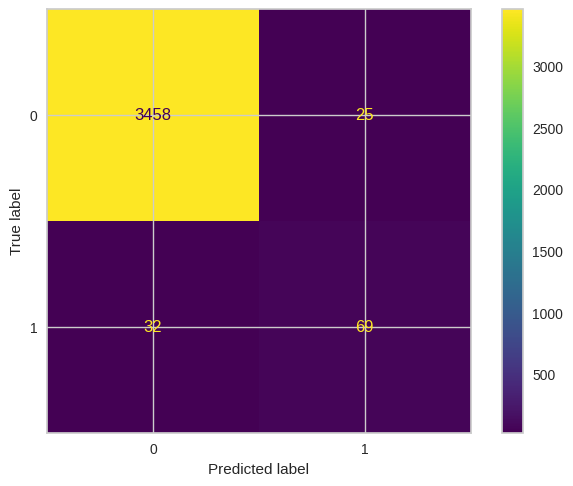

In [76]:
# Визуализация матрицы ошибок.
cm = confusion_matrix(y_test.astype('int').values, y_pred.astype('int').values)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show();

Модель Случайный лес верно предсказала отток клиентов в 87 случаях из 101 и из 3483 лояльных клиентов посчитала ушедшими только 44. Это не самый плохой результат.

In [77]:
predictor_saved.feature_importance(test_data)

Computing feature importance via permutation shuffling for 14 features using 3584 rows with 5 shuffle sets...
	9.12s	= Expected runtime (1.82s per shuffle set)
	4.53s	= Actual runtime (Completed 5 of 5 shuffle sets)


importance    stddev   p_value  n  p99_high   p99_low
OrderQuantity         3.800223e-02  0.003893  0.000013  5  0.046019  0.029986
M                     2.678571e-02  0.003284  0.000027  5  0.033547  0.020025
YearlyIncome          7.868304e-03  0.001780  0.000294  5  0.011533  0.004203
Age                   2.678571e-03  0.001403  0.006487  5  0.005568 -0.000211
CountryAndCity        1.060268e-03  0.000605  0.008628  5  0.002306 -0.000185
HouseOwnerFlag        5.580357e-05  0.000722  0.435610  5  0.001543 -0.001431
Education             0.000000e+00  0.000000  0.500000  5  0.000000  0.000000
Occupation            0.000000e+00  0.000000  0.500000  5  0.000000  0.000000
TotalChildren         0.000000e+00  0.000000  0.500000  5  0.000000  0.000000
NumberChildrenAtHome  0.000000e+00  0.000000  0.500000  5  0.000000  0.000000
NumberCarsOwned       0.000000e+00  0.000000  0.500000  5  0.000000  0.000000
CommuteDistance       0.000000e+00  0.000000  0.500000  5  0.000000  0.000000
MaritalStatus        -4.440892e-17  0.000342  0.500000  5  0.000704 -0.000704
F                    -1.674107e-04  0.000374  0.813050  5  0.000603 -0.000938

Важность всех признаков очень невелика. Самым важным признаком оказалось количество купленных товаров (коэффициент равен 0.048), вторым по выжности - показатель  M из RFM анализа, на третьем месте - годовой доход. То есть обеспеченные люди, уже купившие себе много товаров на большую сумму, скорее всего перестанут обращаться в магазин. У них уже все есть. Остальные признаки имеют важность значительно меньше.

### Прогнозирование оттока покупателей с учетом разбиения на кластеры.

In [78]:
# Добавлю в данные для прогнозирования оттока номера кластеров.
df_churn_plus = df_churn.reset_index().merge(clasters, how='left', on='CustomerKey')
df_churn_plus.isna().sum().sum()

0

In [79]:
df_churn_plus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17918 entries, 0 to 17917
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   CustomerKey           17918 non-null  int64   
 1   Age                   17918 non-null  int64   
 2   MaritalStatus         17918 non-null  category
 3   YearlyIncome          17918 non-null  int64   
 4   Education             17918 non-null  category
 5   Occupation            17918 non-null  category
 6   TotalChildren         17918 non-null  category
 7   NumberChildrenAtHome  17918 non-null  category
 8   HouseOwnerFlag        17918 non-null  category
 9   NumberCarsOwned       17918 non-null  category
 10  CommuteDistance       17918 non-null  category
 11  F                     17918 non-null  category
 12  M                     17918 non-null  category
 13  OrderQuantity         17918 non-null  int64   
 14  Churn                 17918 non-null  category
 15  Co

In [80]:
df_churn_plus = df_churn_plus.set_index('CustomerKey')

In [81]:
# Разделю датафрейм на тренировочную и тестовую выборки.
train_data_plus, test_data_plus = train_test_split(df_churn_plus, test_size=0.2, shuffle=True, stratify=df_churn_plus['Churn'], random_state=42)

In [82]:
train_data_plus.shape, test_data_plus.shape

((14334, 16), (3584, 16))

In [83]:
# Объявляю путь для сохранения модели.
save_path2 = 'agModels-predictClass2'

In [84]:
# Обучаю AutoGluon на тренировочных данных и сохраняю его по указанному пути.
predictor2 = TabularPredictor(label=label, path=save_path2).fit(train_data_plus)

Beginning AutoGluon training ...
AutoGluon will save models to "agModels-predictClass2/"
AutoGluon Version:  0.8.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Aug 30 11:19:59 UTC 2023
Disk Space Avail:   79.28 GB / 115.66 GB (68.5%)
Train Data Rows:    14334
Train Data Columns: 15
Label Column: Churn
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    11462.42 MB
	Train Data (Original)  Memory Usage: 1.48 MB (0.0% of available me

In [85]:
# Выделяю из тестовых данных целевой признак.
y_test_plus = test_data_plus[label]
test_nolab_plus = test_data_plus.drop(columns=[label])

In [86]:
# Загружаю сохраненный предиктор.
predictor_saved_plus = TabularPredictor.load(save_path2)

In [87]:
# Делаю прогноз.
y_pred_plus = predictor_saved_plus.predict(test_nolab_plus)

In [88]:
# Вычисление метрик на тестовых данных.
perf2 = predictor_saved_plus.evaluate_predictions(y_true=y_test_plus, y_pred=y_pred_plus, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9860491071428571
Evaluations on test data:
{
    "accuracy": 0.9860491071428571,
    "balanced_accuracy": 0.8918765261539074,
    "mcc": 0.7553113587410368,
    "f1": 0.761904761904762,
    "precision": 0.7339449541284404,
    "recall": 0.7920792079207921
}


In [89]:
# Сводная таблица результатов предсказания целевого признака моделями фреймворка AutoGluon.
predictor_saved_plus.leaderboard(test_data_plus)

                  model  score_test  score_val  pred_time_test  pred_time_val   fit_time  pred_time_test_marginal  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      RandomForestGini    0.987444   0.989540        0.229642       0.125997   2.169049                 0.229642                0.125997           2.169049            1       True          5
1         LightGBMLarge    0.986607   0.991632        0.068130       0.032918   1.856709                 0.068130                0.032918           1.856709            1       True         13
2      RandomForestEntr    0.986049   0.988842        0.223360       0.128305   1.428643                 0.223360                0.128305           1.428643            1       True          6
3   WeightedEnsemble_L2    0.986049   0.993026        0.322356       0.183515   7.351794                 0.006600                0.006158           2.261461            2       True         14
4              CatBoost    0.985770   0.

model  score_test  score_val  pred_time_test  pred_time_val  \
0      RandomForestGini    0.987444   0.989540        0.229642       0.125997   
1         LightGBMLarge    0.986607   0.991632        0.068130       0.032918   
2      RandomForestEntr    0.986049   0.988842        0.223360       0.128305   
3   WeightedEnsemble_L2    0.986049   0.993026        0.322356       0.183515   
4              CatBoost    0.985770   0.990237        0.046767       0.025145   
5        NeuralNetTorch    0.985770   0.990237        0.070793       0.045823   
6              LightGBM    0.984096   0.991632        0.017983       0.018442   
7        ExtraTreesGini    0.984096   0.987448        0.329450       0.170922   
8       NeuralNetFastAI    0.983817   0.987448        0.144388       0.071658   
9            LightGBMXT    0.983538   0.984658        0.171975       0.076876   
10              XGBoost    0.983259   0.990934        0.045615       0.028683   
11       ExtraTreesEntr    0.983259   0.987448        0.319934       0.182756   
12       KNeighborsUnif    0.977958   0.981172        0.048141       0.046565   
13       KNeighborsDist    0.977958   0.980474        0.058039       0.032463   

     fit_time  pred_time_test_marginal  pred_time_val_marginal  \
0    2.169049                 0.229642                0.125997   
1    1.856709                 0.068130                0.032918   
2    1.428643                 0.223360                0.128305   
3    7.351794                 0.006600                0.006158   
4   16.887080                 0.046767                0.025145   
5   21.501710                 0.070793                0.045823   
6    1.064576                 0.017983                0.018442   
7    2.603042                 0.329450                0.170922   
8   24.770201                 0.144388                0.071658   
9    2.219358                 0.171975                0.076876   
10   3.896725                 0.045615                0.028683   
11   2.530381                 0.319934                0.182756   
12   0.032527                 0.048141                0.046565   
13   0.028196                 0.058039                0.032463   

    fit_time_marginal  stack_level  can_infer  fit_order  
0            2.169049            1       True          5  
1            1.856709            1       True         13  
2            1.428643            1       True          6  
3            2.261461            2       True         14  
4           16.887080            1       True          7  
5           21.501710            1       True         12  
6            1.064576            1       True          4  
7            2.603042            1       True          8  
8           24.770201            1       True         10  
9            2.219358            1       True          3  
10           3.896725            1       True         11  
11           2.530381            1       True          9  
12           0.032527            1       True          1  
13           0.028196            1       True          2

In [90]:
# Матрица ошибок.
confusion_matrix(y_test_plus.astype('int').values, y_pred_plus.astype('int').values)

array([[3454,   29],
       [  21,   80]])

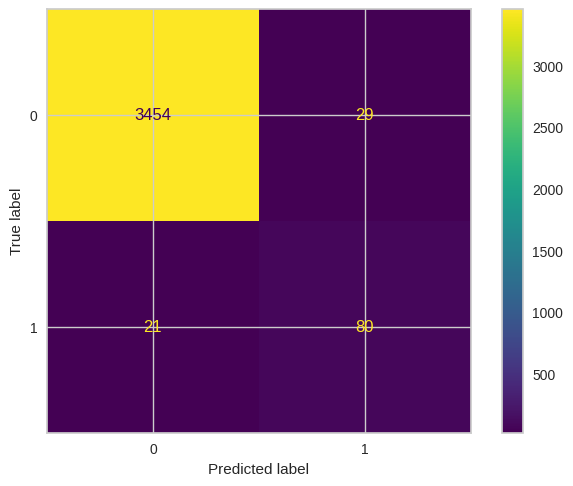

In [91]:
# Визуализация матрицы ошибок.
cm_plus = confusion_matrix(y_test_plus.astype('int').values, y_pred_plus.astype('int').values)
disp_plus = ConfusionMatrixDisplay(confusion_matrix=cm_plus)
disp_plus.plot()
plt.show();

Модель Случайный лес с учетом кластеров верно предсказала отток клиентов в 84 случаях из 101 и из 3483 лояльных клиентов посчитала ушедшими только 38. Этот результат дал бОльшее значение метрики F1-мера, но процент выявленных ушедших клиентов уменьшился.

In [92]:
predictor_saved_plus.feature_importance(test_data_plus)

Computing feature importance via permutation shuffling for 15 features using 3584 rows with 5 shuffle sets...
	23.7s	= Expected runtime (4.74s per shuffle set)
	7.57s	= Actual runtime (Completed 5 of 5 shuffle sets)


importance    stddev   p_value  n  p99_high   p99_low
OrderQuantity         3.828125e-02  0.004243  0.000018  5  0.047017  0.029546
M                     2.795759e-02  0.003091  0.000018  5  0.034321  0.021594
YearlyIncome          7.645089e-03  0.001055  0.000042  5  0.009818  0.005473
Age                   1.841518e-03  0.001210  0.013592  5  0.004332 -0.000649
HouseOwnerFlag        6.138393e-04  0.000306  0.005450  5  0.001243 -0.000015
CountryAndCity        5.580357e-04  0.000279  0.005528  5  0.001133 -0.000016
MaritalStatus         4.464286e-04  0.000467  0.049650  5  0.001408 -0.000515
Cluster               1.116071e-04  0.000423  0.293525  5  0.000983 -0.000760
F                    -4.440892e-17  0.000764  0.500000  5  0.001573 -0.001573
CommuteDistance      -1.116071e-04  0.000374  0.729265  5  0.000659 -0.000882
Education            -1.674107e-04  0.000153  0.964758  5  0.000147 -0.000482
NumberCarsOwned      -1.674107e-04  0.000250  0.896000  5  0.000346 -0.000681
TotalChildren        -2.790179e-04  0.000483  0.866868  5  0.000716 -0.001274
Occupation           -3.348214e-04  0.000364  0.945650  5  0.000414 -0.001084
NumberChildrenAtHome -4.464286e-04  0.000153  0.998581  5 -0.000132 -0.000761

Номер кластера находится на 4 месте по важности.

Добаление номера кластера привело к увеличению значения метрики F1-мера (0.7534). Это говорит в пользу того, что кластеры определены достаточно хорошо. Однако, при большей точности процент правильно предсказанного оттока уменьшился.

## Выводы

Передо мной была поставлена задача на основании предоставленных данных о продаже велосипедов и сопутствующих товаров в 2014-2016 годах:
1. Построить модель, позволяющую с достаточной точностью прогнозировать размер прибыли в следующем за отчетным  периоде.
2. Построить модель, позволяющую по имеющимся данным разделять покупателей на группы с целью более актуальных для каждой группы маркетинговых предложений.
3. Построить модель, позволяющую с достаточной точностью предсказывать отток покупателей.

Полученные данные были консолидированы и очищены.

1. <b>Прогнозирование прибыли на следующий период.</b>

Для построения модели прогнозирования прибыли на следующий период был использован фреймворк автоматического машинного обучения Prophet.

Из исходных данных был выделен временной ряд, содержащий агрегированную по неделям прибыль. Период прогнозирования был определен размером в 8 недель. Из временного ряда были выделены тестовая выборка рамеров в 8 недель и тренировочная выборка, включающая все оставшиеся данные.

На тренировочной выборке была обучена модель и с ее помощью на выделенном из тестовой выборки временном интервале был сделан прогноз прибыли.

Средняя абсолютная ошибка прогноза MAE составила 63786 долларов. Размер прибыли в последнюю неделю предыдущего периода составил 232862 долларов, то есть ошибка составила 27%.

На построенном графике актуального и прогнозированного временных радов видно, что прогноз на первые 4 недели достаточно точный. Это говорит о том, что для точного прогнозирования не 8 недель вперед нужно использовать более длительный период исходных данных.

2. <b>Разделение покупателей на группы.</b>

Для решения задачи кластеризации был создан агрегированный по покупателям датафрейм, содержащий персональные данные, а также параметры частота и сумма трат, полученные в результате RFM анализа и общее количествокупленных товаров.

Все категориальные признаки были приведены к типу category, там где это имеет смысл - категории упорядочены.

Разделение на кластеры проводилось с помощью фреймворка автоматического машинного обучения PyCaret методом K-means.

В результате покупатели были разделены на 9 кластеров. При разбиении удалось достичь следующих значений показателей: оценка силуэта = 0.8, индекс Калински-Харабаша = 175466 и индекс Дэвиса-Булдина = 0.36.

3. <b>Прогнозирование оттока клиентов.</b>

Для прогнозирования ухода покупателей был использован агрегированный по покупателям датафрейм из задачи кластеризации.

На основании информации о давности последней покупки был создан целевой признак.Было решено считать покупателя ушедшим, если дата его последней покупки была ранее одного года с даты конца периода. Признак Recency был удален во избежание утечки данных.

Ушедших покупателей оказалось всего 2.8% от всего количества. Это значит, что мы решали задачу с сильным дисбалансом классов.

Данные были разделены на тренировочную и тестовую выборки в соотношении 80:20 с сохранением соотношения классов.

В результате анализа взаимной корреляции признаков стало ясно, что географические данные (регион, группа, страна, штат, город) имеют сильную взаимную корреляцию ( коэффициент корреляции равен 1). Было принято решение содать один признак, включающий в себя страну и город, а остальные удалить.

Признак Gender показал практически нулевую корреляцию со всеми признаками, включая целевой. Его также было решено удалить. После этого можно было приступать к машинному обучению.

Фреймворк AutoGluon обучил 13 моделей. Лучший результат показала модель RandomForest с критерием entropy. Она показала на тестовой выборке значение метрики F1-мера = 0.75, precision=0.66, recall=0.86.

Самым важным признаком оказалось количество купленных товаров (коэффициент равен 0.048), вторым по выжности - показатель M из RFM анализа, на третьем месте - годовой доход. То есть обеспеченные люди, уже купившие себе много товаров на большую сумму, скорее всего перестанут обращаться в магазин. У них уже все есть. Остальные признаки имеют важность значительно меньше.

Добаление номера кластера привело к увеличению значения метрики F1-мера (0.7534). Это говорит в пользу того, что кластеры определены достаточно хорошо. Однако, при большей точности процент правильно предсказанного оттока уменьшился.

Очень важных признаков для прогнозировании оттока нет, поэтому и качество модели неидеально. Однако для проведения маркетинговых мероприятий пртиводействия оттоку клиентов эта модель будет хорошей подмогой.